# INSTALL DEPENDENCIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
colorImgBgr = cv2.imread(r'../../Downloads/download.png')
grayImg = cv2.imread(r'../../Downloads/puppy.jpeg', cv2.IMREAD_GRAYSCALE)
grayAlb = cv2.imread(r'../../Downloads/albert-einstein_gray.jpg', cv2.IMREAD_GRAYSCALE)

In [3]:
import matplotlib as mpl
def displayImageInActualSize(img):
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    plt.show

def displayImageInActualSizeColor(img):
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape[0:2]
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img)
    plt.show

# BILINEAR TRANSFORMATION

In [4]:
def f_bilinearInterpolate(row, col, I):
    leftCol = int(col)
    rightCol = leftCol + 1
    widthLeft = col - leftCol
    widthRight = rightCol - col
    topRow = int(row)
    bottomRow = topRow + 1
    widthTop = row - topRow
    widthBottom = bottomRow - row
    if topRow >= 0 and bottomRow < I.shape[0] and leftCol >= 0 and rightCol < I.shape[1]:
        a = I[topRow, leftCol] * widthRight + I[topRow, rightCol] * widthLeft
        b = I[bottomRow, leftCol] * widthRight + I[bottomRow, rightCol] * widthLeft
        g = widthTop * b + widthBottom * a
        return np.uint8(g)
    else:
        return 0

# ROTATION IMPLEMENTATION

In [5]:
def f_getExtents(T, rMax, cMax):
    coords = np.array([[0,0], [0, cMax - 1], [rMax - 1, 0], [rMax - 1, cMax -1]])
    A_dash = T.dot(coords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [6]:
def f_transform(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtents(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j])
            P = Tinv.dot(P_dash)
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

# AFFINE TRANSFORMATION

In [7]:
def f_getExtentsAffine(T, rMax, cMax):
    coords = np.array([[0,0, 1], [0, cMax - 1, 1], [rMax - 1, 0, 1], [rMax - 1, cMax -1, 1]])
    A_dash = T.dot(coords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [8]:
def f_transformAffine(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtentsAffine(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j, 1])
            P = Tinv.dot(P_dash)
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

/home/linuxbrew/.linuxbrew/opt/python@3.12/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/linuxbrew/.linuxbrew/opt/python@3.12/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


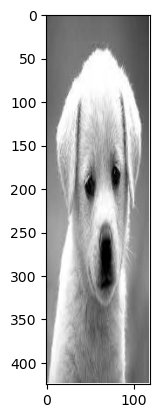

In [9]:
T = np.array([[2, 0, 10],[0, 0.5, 20],[0, 0, 1]])
img = f_transformAffine(T, grayImg)
plt.imshow(img, cmap='gray')

## Rotation in the new center

In [10]:
degree = 45
cosA = np.cos(np.deg2rad(degree))
sinA = np.sin(np.deg2rad(degree))
R = np.array([[cosA, -sinA, 0],[sinA, cosA, 0],[0, 0, 1]])
T = np.array([[1, 0, -300],[0, 1, -400],[0, 0, 1]])
A = np.linalg.inv(T).dot(R).dot(T)
A

array([[  0.70710678,  -0.70710678, 370.71067812],
       [  0.70710678,   0.70710678, -94.97474683],
       [  0.        ,   0.        ,   1.        ]])

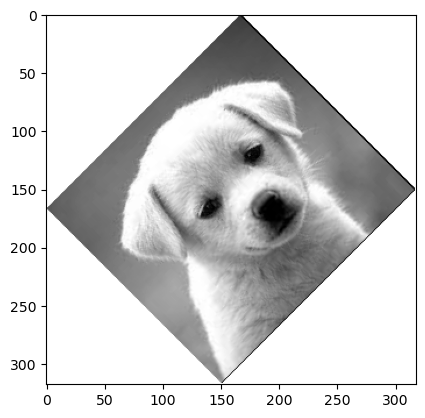

In [11]:
img = f_transformAffine(A, grayImg)
plt.imshow(img, cmap='gray')

In [12]:
a = 45
ca = np.cos(np.deg2rad(a))
sa = np.sin(np.deg2rad(a))
R = np.array([[ca,-sa,0],[sa,ca,0],[0,0,1]])
T = np.array([[1,0,-300],[0,1,-400],[0,0,1]])
Sh = np.array([[1,0.5,0],[0,1,0],[0,0,1]])
S = np.array([[1.3,0,0],[0,0.7,0],[0,0,1]])
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T)

In [13]:
A

array([[  0.91923882,  -0.45961941, 208.07611845],
       [  0.49497475,   0.74246212, -45.47727215],
       [  0.        ,   0.        ,   1.        ]])

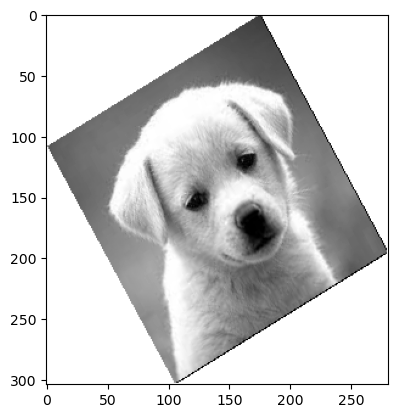

In [14]:
I2 = f_transformAffine(A,grayImg)
plt.imshow(I2,cmap='gray')

## REFLECTION ABOUT A LINE 

In [15]:
a = -45
ca = np.cos(np.deg2rad(a))
sa = np.sin(np.deg2rad(a))
R = np.array([[ca,-sa,0],[sa,ca,0],[0,0,1]])
T = np.array([[1,0,-2],[0,1,0],[0,0,1]])
Rf = np.array([[1,0,0],[0,-1,0],[0,0,1]])
A = np.linalg.inv(T).dot(np.linalg.inv(R)).dot(Rf).dot(R).dot(T)

In [16]:
A

array([[ 1.99673462e-16,  1.00000000e+00,  2.00000000e+00],
       [ 1.00000000e+00, -1.79380389e-16, -2.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

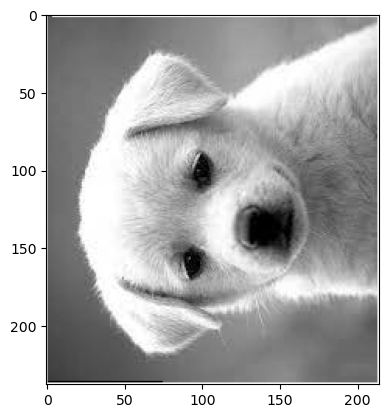

In [17]:
I2 = f_transformAffine(A,grayImg)
plt.imshow(I2,cmap='gray')

In [18]:
a = 30
ca = np.cos(np.deg2rad(a))
sa = np.sin(np.deg2rad(a))
R = np.array([[ca,-sa],[sa,ca]])
np.linalg.det(R)

1.0

In [19]:
np.linalg.inv(R)

array([[ 0.8660254,  0.5      ],
       [-0.5      ,  0.8660254]])

In [20]:
R.T

array([[ 0.8660254,  0.5      ],
       [-0.5      ,  0.8660254]])

In [21]:
Rf = R[[1,0],:]

In [22]:
Rf

array([[ 0.5      ,  0.8660254],
       [ 0.8660254, -0.5      ]])

In [23]:
np.linalg.det(Rf)

-1.0

In [24]:
Rf.T

array([[ 0.5      ,  0.8660254],
       [ 0.8660254, -0.5      ]])

In [25]:
np.linalg.inv(Rf)

array([[ 0.5      ,  0.8660254],
       [ 0.8660254, -0.5      ]])

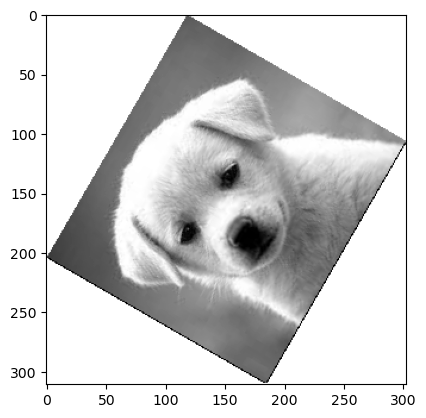

In [26]:
A = np.array([[Rf[0,0],Rf[0,1],0],[Rf[1,0],Rf[1,1],0],[0,0,1]])
img = f_transformAffine(A, grayImg)
plt.imshow(img, cmap='gray')

# PROJECTIVE TRANSFORMATION HOMOGRAPHY

In [27]:
def f_getExtentsProjective(T, rMax, cMax):
    coords = np.array([[0,0, 1], [0, cMax - 1, 1], [rMax - 1, 0, 1], [rMax - 1, cMax -1, 1]])
    A_dash = T.dot(coords.T)
    A_dash = A_dash/A_dash[2,:]
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [44]:
def f_transformProjective(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtentsProjective(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j, 1])
            P = Tinv.dot(P_dash)
            P = P/P[2]
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

In [52]:
a = 30
ca = np.cos(np.deg2rad(a))
sa = np.sin(np.deg2rad(a))
R = np.array([[ca,-sa,0],[sa,ca,0],[0,0,1]])
T = np.array([[1,0,-300],[0,1,-400],[0,0,1]])
Sh = np.array([[1,0.5,0],[0,1,0],[0,0,1]])
S = np.array([[1.3,0,0],[0,0.7,0],[0,0,1]])
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T)
H = np.array(A)
A

array([[  1.12583302,  -0.08708349,  -2.91651246],
       [  0.35      ,   0.78121778, -17.48711306],
       [  0.        ,   0.        ,   1.        ]])

In [107]:
H[2,:] = np.array([0.0026, 0.001, 1])
H

array([[ 1.12583302e+00, -8.70834875e-02, -2.91651246e+00],
       [ 3.50000000e-01,  7.81217783e-01, -1.74871131e+01],
       [ 2.60000000e-03,  1.00000000e-03,  1.00000000e+00]])

In [108]:
A

array([[  1.12583302,  -0.08708349,  -2.91651246],
       [  0.35      ,   0.78121778, -17.48711306],
       [  0.        ,   0.        ,   1.        ]])

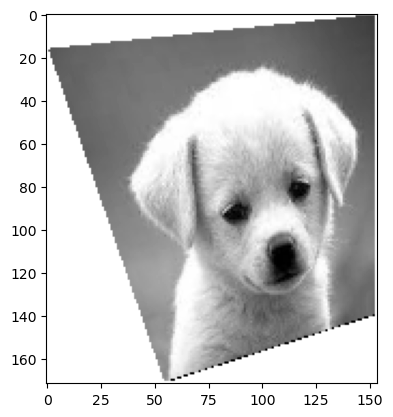

In [109]:
I2 = f_transformProjective(H,grayImg)
plt.imshow(I2,cmap='gray')